# Moving Averages Trading Strategy
##### Here I present a moving averages trading strategy applied on the S&P500 Composite index to investigate if I could have outperformed a pure long position in the index.

#### The strategy is to buy the index on the period after I detect the shorter moving average crossing upwards the longer moving average, as this is a sign of positive momentum. Similarly, I sell the index right after detecting the shorter moving average crossing downward the longer moving average.

In [1]:
# Import libraries and initialise variables.

import numpy as np
import quandl
import pandas as pd

t=6 # time frame (in months) to calculate the short moving average
T=24 # time frame (in months) to calculate the long moving average
rf = 0.01 # assumed risk free rate

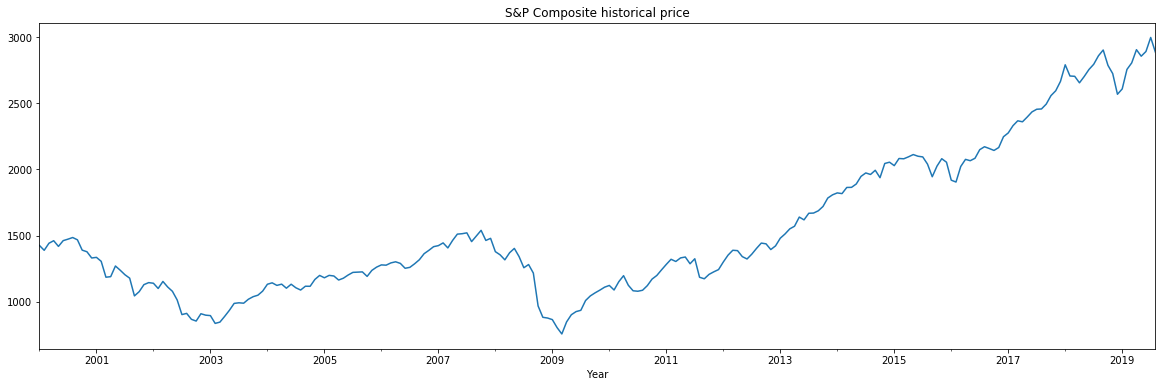

In [3]:
# Get data from Quandl, keep only closeing price and plot historic data.

quandl.ApiConfig.api_key = "MYQUANDLAPIKEY"
spy = quandl.get("YALE/SPCOMP", start_date = "2000-01-01")

del spy["Dividend"], spy["Earnings"], spy["CPI"], spy["Long Interest Rate"], spy["Real Price"], spy["Real Dividend"], spy["Real Earnings"], spy["Cyclically Adjusted PE Ratio"]

spy["S&P Composite"].plot(figsize = (20,6), title = 'S&P Composite historical price')

In [4]:
# Calculate a short and long moving average and set a position. Long when the short MA crosses upwards the Long MA.
# We assume no shorting, so the position when short MA crosses downward the long MA is 0, not -1.
# The position is shifted down 1 day becasue we buy/sell the day after the signal is given.

spy["MA_Short"] = spy["S&P Composite"].rolling(t).mean()
spy["MA_Long"] = spy["S&P Composite"].rolling(T).mean()

spy["Position"] = np.where(spy["MA_Short"]>spy["MA_Long"],1,0)
spy["Position"] = spy["Position"].shift(1)

In [5]:
# Print head and tail to check for errors.

print(spy.head())
print(spy.tail())

            S&P Composite  MA_Short  MA_Long  Position
Year                                                  
2000-01-31        1425.59       NaN      NaN       NaN
2000-02-29        1388.87       NaN      NaN       0.0
2000-03-31        1442.21       NaN      NaN       0.0
2000-04-30        1461.36       NaN      NaN       0.0
2000-05-31        1418.48       NaN      NaN       0.0
            S&P Composite     MA_Short      MA_Long  Position
Year                                                         
2019-04-30        2903.80  2726.761667  2668.901667       1.0
2019-05-31        2854.71  2748.675000  2688.041667       1.0
2019-06-30        2890.17  2802.485000  2707.049167       1.0
2019-07-31        2996.11  2867.271667  2729.632917       1.0
2019-08-31        2883.98  2888.791667  2747.456250       1.0


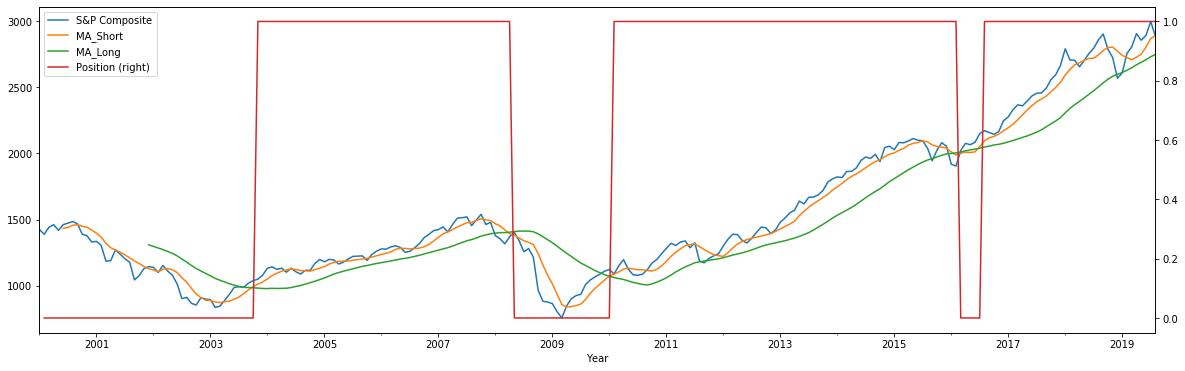

In [6]:
# Plot results.

spy[["S&P Composite", "MA_Short", "MA_Long", "Position"]].plot(figsize = (20,6), secondary_y = "Position")

In [7]:
# Drop values where strategy cant be applied due to lack of data.
# Calculate log returns of the baseline (S&P Comp index) and strategy.
# We accumulate returns to compare the performance of the strategy against the baseline.

spy.dropna(inplace = True)

spy["Baseline_Return"] = np.log(spy["S&P Composite"]/spy["S&P Composite"].shift(1))
spy["Strategy_Return"] = spy["Baseline_Return"] * spy["Position"]

spy["Baseline_cumReturn"] = spy["Baseline_Return"].cumsum()
spy["Strategy_cumReturn"] = spy["Strategy_Return"].cumsum()

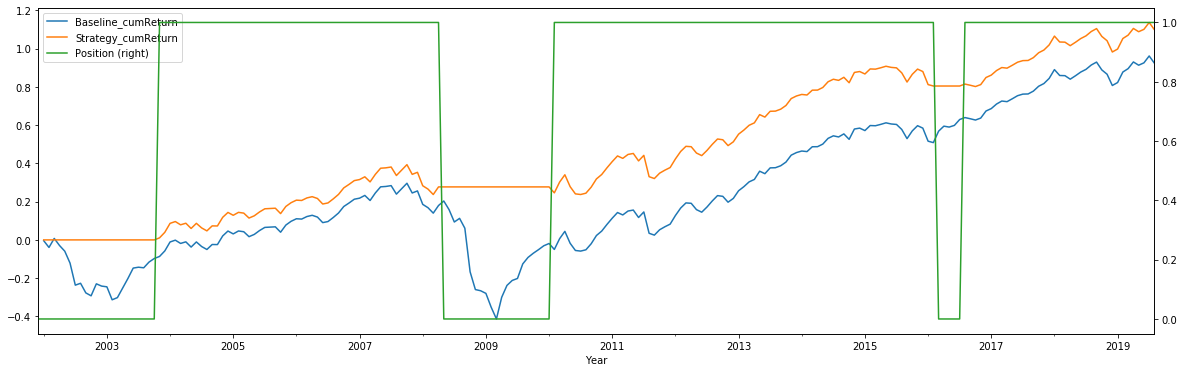

In [8]:
spy[["Baseline_cumReturn", "Strategy_cumReturn", "Position"]].plot(figsize = (20,6), secondary_y = "Position")

In [9]:
# Calculate mean and standard deviation of returns for the baseline and strategy to determine the Sharp Ratios.
Baseline_return = spy["Baseline_Return"].mean()
Baseline_annualReturn = Baseline_return * 12

Strategy_return = spy["Strategy_Return"].mean()
Strategy_annualReturn = Strategy_return * 12

Baseline_std = spy["Baseline_Return"].std()
Baseline_annualStd = Baseline_std * np.sqrt(12)

Strategy_std = spy["Strategy_Return"].std()
Strategy_annualStd = Strategy_std * np.sqrt(12)

Baseline_SR = (Baseline_annualReturn - rf)/Baseline_annualStd
Strategy_SR = (Strategy_annualReturn - rf)/Strategy_annualStd

In [10]:
# Present results in a small table comparing cumulative returns and sharp ratios.
# Strategy clearly outperforms the baseline both in absoute returns and in a per unit of risk basis.

Baseline_cumReturn = spy.iloc[-1].at['Baseline_cumReturn']
Strategy_cumReturn = spy.iloc[-1].at['Strategy_cumReturn']


results = {"Baseline" : [Baseline_cumReturn, Baseline_SR],
           "Strategy" : [Strategy_cumReturn, Strategy_SR]}

df_results = pd.DataFrame(results, index = ["cumReturn", "Sharp Ratio"])

df_results

,Baseline,Strategy
cumReturn,0.923828,1.099028
Sharp Ratio,0.336066,0.626344


#### This trading strategy overperforms its benchmark on an absolute and per-unit-of-risk basis.